# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

## 0. Import Requirements

In [82]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily, Hourly
import datetime
import seaborn as sns
import torch
import torch.nn as nn
from copy import deepcopy as dc
import holidays

## 1. Data Exploration

In [83]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [84]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [85]:
visitor_data.describe()

,value
count,3782.000000
mean,2.870968
std,3.526116
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,20.000000


<Axes: xlabel='timestemp'>

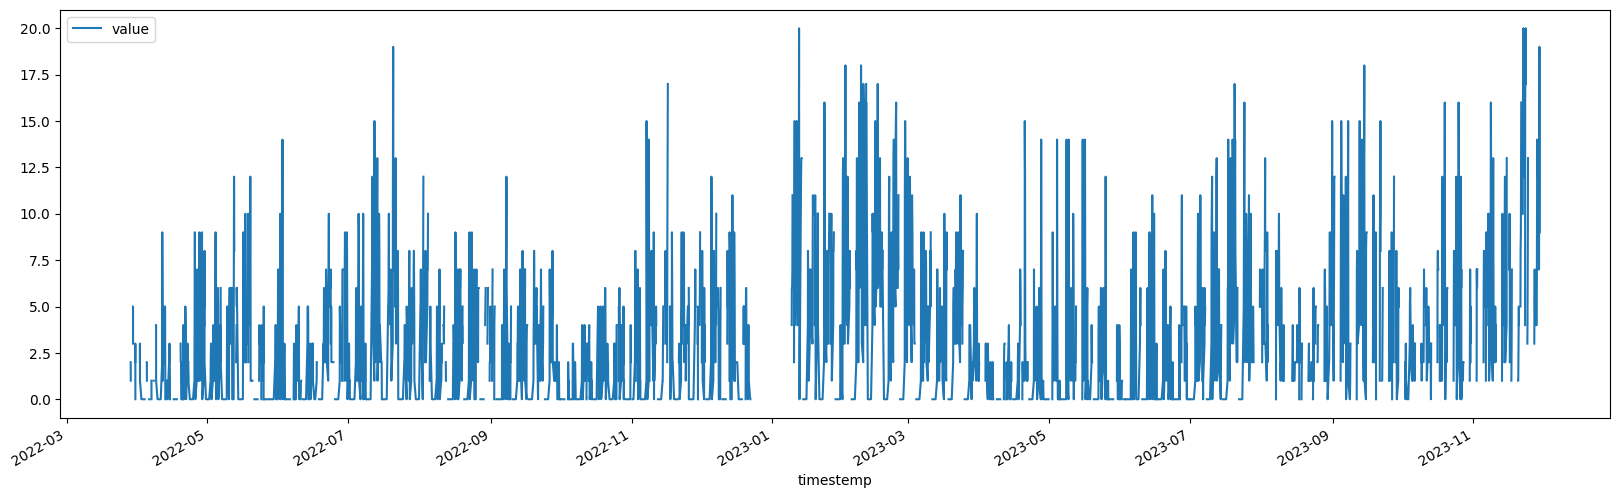

In [86]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 2. Data Preprocessing

- Missing Values
- Sequenz der Vergangenheitswerte
- Datum extrahieren
- Wochentag anhand des Datums herausfinden
- Wochentag oder Wochenende?
    - alle Wocheendtage = 0
- Prüfungsphase hinzufügen
- Holiday/Ferien/Feiertage
- Wetterdaten

In [87]:
# Missing Values Handling
visitor_data['value'] = visitor_data['value'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)

<Axes: xlabel='timestemp'>

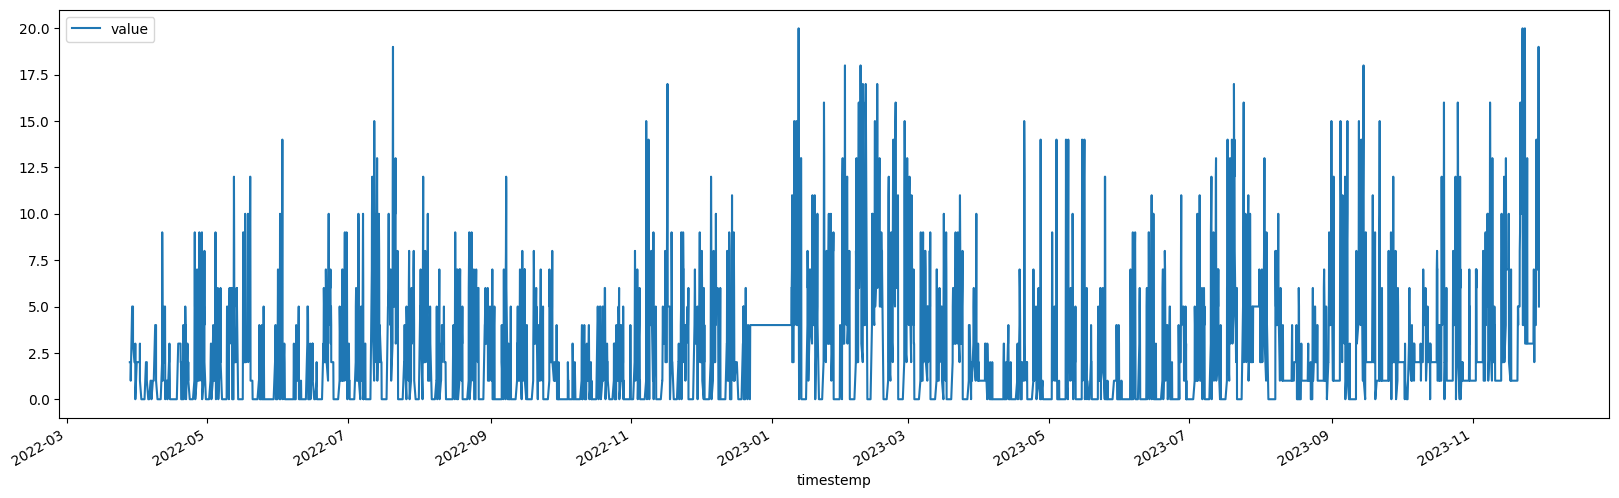

In [88]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

In [89]:
# Die Vergangeheitswerte t-1 etc. bekommen
def prepare_dateframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps + 1):
        df[f'value (t-{i})'] = df['value'].shift(i)

    return df

lookback = 7 # Hier rumspielen
visitor_data = prepare_dateframe_for_lstm(visitor_data, lookback)
#visitor_data

# wenn wir zei Wochen übergeben wollen, müssen wir 8*14=114 Werte zurück gehen...

In [90]:
# das Datum extrahieren
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list

#visitor_data

In [91]:
# add column "weekday"
visitor_data["weekday"] = [weekday for weekday in visitor_data["timestemp"].dt.dayofweek]
#visitor_data

In [92]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 5 or timestemp == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list
#visitor_data

In [93]:
# Set all values, where weekend day is 1 to 0
visitor_data.loc[visitor_data['weekend'].eq(1), 'value'] = 0
#visitor_data[["value", "weekend"]]

In [94]:
# Vorlesungspahse = 0, Pfürungsphase = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [95]:
visitor_data

exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list
#visitor_data

In [96]:
# Check if holiday, or not; holiday = 1, else = 0

In [97]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-20,5.6,4.8,7.0,0.5,0.0,250.0,13.3,44.3,1019.1,144.0
2023-12-21,8.1,5.5,10.5,0.9,0.0,238.0,23.7,69.0,1007.3,NaN
2023-12-22,7.9,6.7,9.2,9.8,0.0,281.0,31.6,80.0,1007.5,NaN


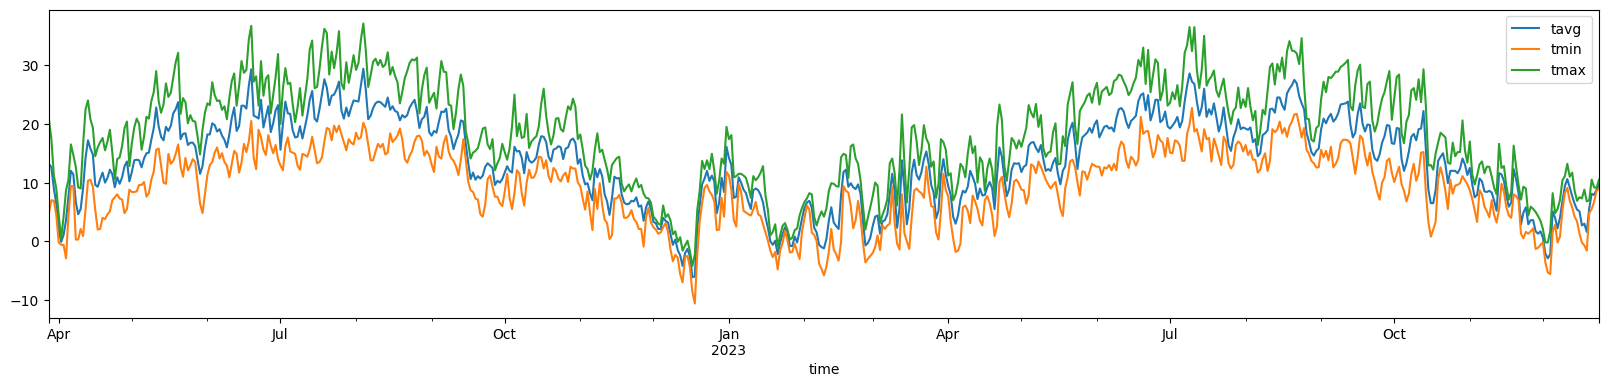

In [98]:
weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
plt.show()

In [99]:
# merge data frames
visitor_data = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time"
)

visitor_data

,timestemp,value,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),value (t-7),date,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-03-28 09:30:00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
1,2022-03-28 10:45:00,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2,2022-03-28 13:45:00,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
3,2022-03-28 16:15:00,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
4,2022-03-28 17:45:00,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,19.0,7.0,7.0,7.0,11.0,11.0,12.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4892,2023-11-29 17:45:00,9.0,19.0,19.0,7.0,7.0,7.0,11.0,11.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4893,2023-11-29 18:00:00,5.0,9.0,19.0,19.0,7.0,7.0,7.0,11.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4894,2023-11-29 18:30:00,5.0,5.0,9.0,19.0,19.0,7.0,7.0,7.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


In [100]:
visitor_data.set_index('timestemp', inplace=True)
visitor_data

,value,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),value (t-7),date,weekday,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-03-28 09:30:00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 10:45:00,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 13:45:00,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 16:15:00,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 17:45:00,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 16:15:00,19.0,19.0,7.0,7.0,7.0,11.0,11.0,12.0,2023-11-29,2,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
2023-11-29 17:45:00,9.0,19.0,19.0,7.0,7.0,7.0,11.0,11.0,2023-11-29,2,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
2023-11-29 18:00:00,5.0,9.0,19.0,19.0,7.0,7.0,7.0,11.0,2023-11-29,2,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


In [101]:
#calculate correlations between all features of your data frame (see Exploration lab)
data_corr = visitor_data.corr()
print(data_corr)

                value  value (t-1)  value (t-2)  value (t-3)  value (t-4)  \
value        1.000000     0.736738     0.519347     0.362129     0.290284   
value (t-1)  0.736738     1.000000     0.750107     0.529325     0.369926   
value (t-2)  0.519347     0.750107     1.000000     0.750079     0.529269   
value (t-3)  0.362129     0.529325     0.750079     1.000000     0.750121   
value (t-4)  0.290284     0.369926     0.529269     0.750121     1.000000   
value (t-5)  0.280638     0.297393     0.370152     0.529918     0.750343   
value (t-6)  0.354582     0.289083     0.297428     0.370381     0.529482   
value (t-7)  0.447625     0.364755     0.288949     0.297297     0.370052   
weekday     -0.425655    -0.363240    -0.338586    -0.307233    -0.268954   
weekend     -0.473502    -0.408479    -0.396739    -0.384163    -0.370855   
exam_phase   0.112178     0.112463     0.114562     0.116797     0.119515   
tavg        -0.107530    -0.110958    -0.111265    -0.111259    -0.110247   

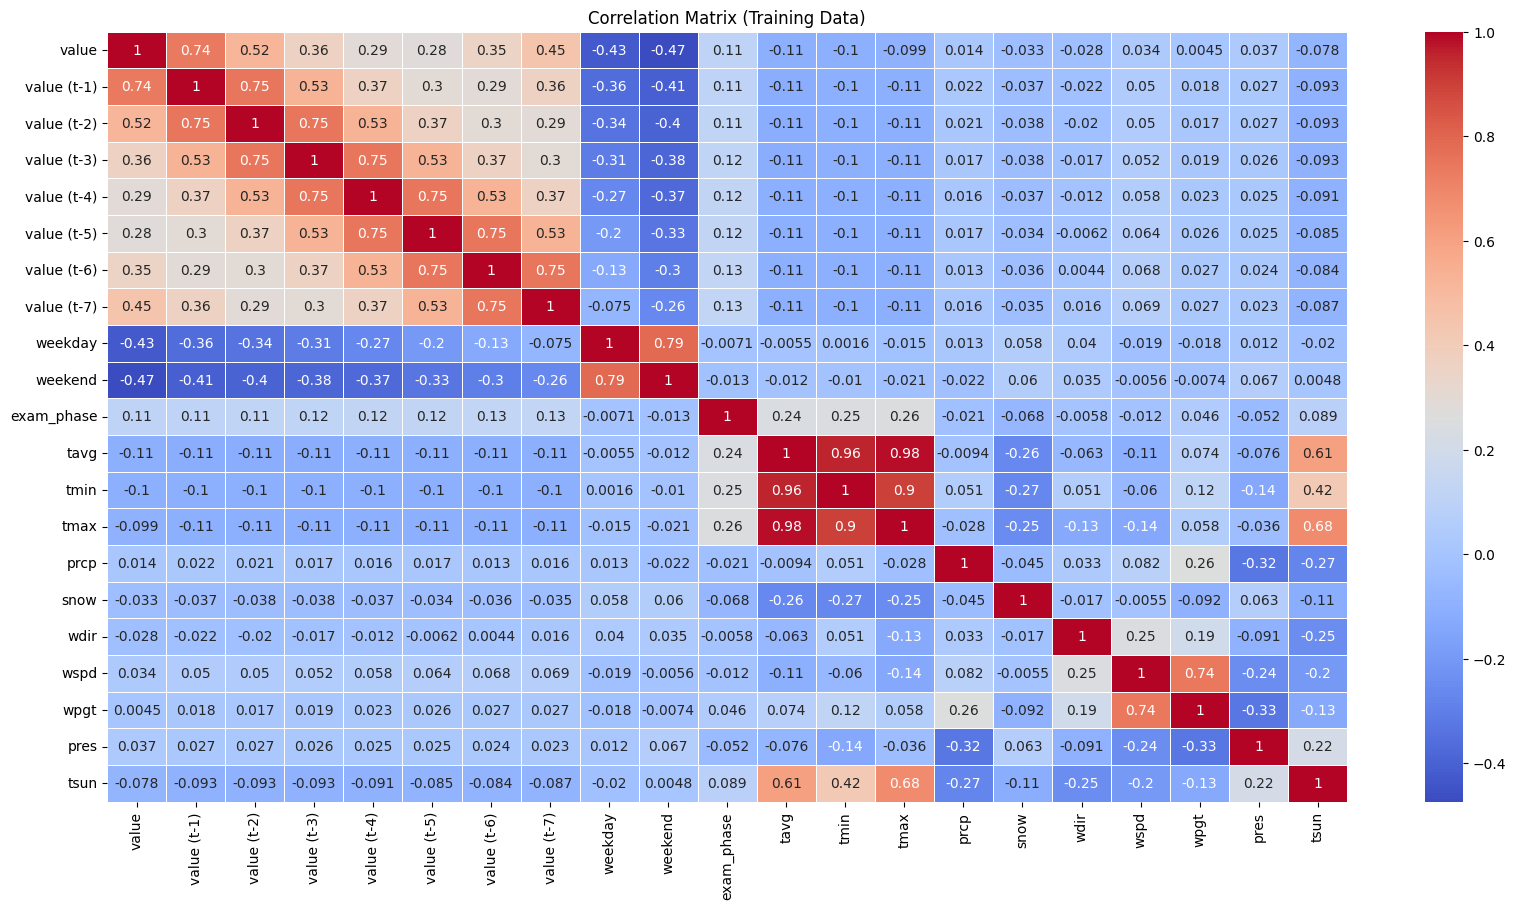

In [102]:
# Compute the correlation matrix for all columns
correlation_matrix = visitor_data.corr()

# Create a heatmap of the entire correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix (Training Data)')
plt.show()

In [103]:
data_corr_label = visitor_data.iloc[:, :].corr()["value"]
data_corr_label[:10]

value          1.000000
value (t-1)    0.736738
value (t-2)    0.519347
value (t-3)    0.362129
value (t-4)    0.290284
value (t-5)    0.280638
value (t-6)    0.354582
value (t-7)    0.447625
weekday       -0.425655
weekend       -0.473502
Name: value, dtype: float64

## 3. Prepare Data for Model

In [104]:
visitor_data.shape

(4896, 22)

In [105]:
data_array = visitor_data.to_numpy()

data_array

array([[2.0, nan, nan, ..., 30.6, 1021.4, 630.0],
       [2.0, 2.0, nan, ..., 30.6, 1021.4, 630.0],
       [2.0, 2.0, 2.0, ..., 30.6, 1021.4, 630.0],
       ...,
       [5.0, 9.0, 19.0, ..., 29.5, 1007.5, 72.0],
       [5.0, 5.0, 9.0, ..., 29.5, 1007.5, 72.0],
       [nan, 5.0, 5.0, ..., 29.5, 1007.5, 72.0]], dtype=object)

In [106]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# shifted_df_as_np = scaler.fit_transform(data_array)

# shifted_df_as_np

In [107]:
data_array.shape

(4896, 22)

## 4. Build Model

In [108]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (
            torch.zeros(num_layers, 1, self.hidden_layer_size),
            torch.zeros(num_layers, 1, self.hidden_layer_size),
        )

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell
        )
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


input_size = 22
hidden_layer_size = 100
output_size = 1
num_layers = 1

model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# todo: Training loop